In [221]:
from dataclasses import dataclass
import numpy as np 
from typing import Iterable, Optional

ConstraintList = Iterable[tuple[int, int]]

@dataclass
class Spec:
    num_peptides : int
    max_peptides_per_pool : int
    num_replicates : int
    invalid_neighbors : ConstraintList

@dataclass
class Solution(Spec):
    assignments : dict[int, dict[int, Iterable[int]]]
    
def random_init(
        num_peptides : int = 100, 
        peptides_per_pool : int = 5,
        num_replicates : int = 3,
        num_pools : Optional[int] = None,
        invalid_neighbors : ConstraintList = []) -> Solution:
    if num_pools is None:
        num_pools = int(np.ceil(num_peptides / peptides_per_pool)) 
        print(num_pools)
    replicate_to_pool_to_peptides = {}
    for i in range(num_replicates):
        peptide_array = np.arange(num_peptides)
        np.random.shuffle(peptide_array)
        pool_assignments = {}
        replicate_to_pool_to_peptides[i] = pool_assignments
        
        for j in range(num_pools):
            start_idx = peptides_per_pool * j
            end_idx = peptides_per_pool * (j + 1)
            pool_assignments[j] = peptide_array[start_idx:end_idx]
    return Solution(
        num_peptides=num_peptides,
        max_peptides_per_pool=peptides_per_pool,
        num_replicates=num_replicates,
        invalid_neighbors=invalid_neighbors,
        assignments=replicate_to_pool_to_peptides)

            

In [222]:
s = random_init()
s

20


Solution(num_peptides=100, max_peptides_per_pool=5, num_replicates=3, invalid_neighbors=[], assignments={0: {0: array([57, 66, 28, 41, 50]), 1: array([ 7, 12,  3, 10, 34]), 2: array([68,  8, 22, 87, 35]), 3: array([21, 59, 56,  4, 32]), 4: array([27, 99, 36, 44, 67]), 5: array([93, 78, 17, 97, 42]), 6: array([ 1, 33, 86, 40,  0]), 7: array([60, 90,  6, 94, 43]), 8: array([55, 37, 81, 96, 69]), 9: array([51, 45, 14, 88, 19]), 10: array([16, 62, 11, 52, 89]), 11: array([64, 70, 76, 92, 73]), 12: array([95, 83, 29, 46, 26]), 13: array([58, 72, 25, 49, 79]), 14: array([39, 31, 65, 91, 85]), 15: array([13, 75, 48, 20, 80]), 16: array([71, 82, 63, 47, 30]), 17: array([38, 18,  2, 23, 24]), 18: array([53, 77, 74,  9, 98]), 19: array([15, 84,  5, 61, 54])}, 1: {0: array([38, 50, 60, 66, 29]), 1: array([41, 44, 80, 64, 89]), 2: array([58, 16, 97, 10, 73]), 3: array([65, 62, 18, 42, 23]), 4: array([96, 36, 51, 56, 40]), 5: array([85, 48, 25,  6,  4]), 6: array([ 9, 76, 88, 92, 52]), 7: array([ 5

In [203]:
from collections import defaultdict

def is_valid(s : Solution) -> bool:
    
    peptide_to_neighbors = defaultdict(set)

    
    if s.invalid_neighbors:
        # treat invalid pairs as if they've already been neighbors in a previous round
        for (p1, p2) in invalid_neighbors:
            peptide_to_neighbors[p1].add(p2)
            peptide_to_neighbors[p2].add(p1)
    
    for replicate_idx, pool_to_peptides in s.assignments.items():
        replicate_num = replicate_idx + 1
        
        # first check each peptide occurs once per replicate
        seen_peptides = set()
        for peptides in pool_to_peptides.values():
            for p in peptides:
                if p in seen_peptides:
                    print("Peptide %s twice in replicate %s" % (p, replicate_num))
                    return False
                seen_peptides.add(p)
        # next check to make sure that each peptides only paired with another at most once
        for peptides in pool_to_peptides.values():
            for p1 in peptides:
                for p2 in peptides:
                    if p1 != p2:
                        if p2 in peptide_to_neighbors[p1]:
                            print("Peptides %s and %s already together previous pool before replicate %s" % (p1, p2, replicate_num))
                            return False
                        peptide_to_neighbors[p1].add(p2)
    return True 



In [204]:
is_valid(s)

Peptides 18 and 13 already together previous pool before replicate 2


False

In [205]:


def count_violations(s : Solution) -> int:
    invalid_neighbors = s.invalid_neighbors
    replicate_to_pool_to_peptides = s.assignments
    
    peptide_to_neighbors = defaultdict(set)
    
    if invalid_neighbors:
        # treat invalid pairs as if they've already been neighbors in a previous round
        for (p1, p2) in invalid_neighbors:
            peptide_to_neighbors[p1].add(p2)
            peptide_to_neighbors[p2].add(p1)
    
    violations = 0
    for _, pool_to_peptides in replicate_to_pool_to_peptides.items():

        
        # first check each peptide occurs once per replicate
        seen_peptides = set()
        for peptides in pool_to_peptides.values():
            for p in peptides:
                if p in seen_peptides:
                    violations +=1 
                else:
                    seen_peptides.add(p)
        # next check to make sure that each peptides only paired with another at most once
        for peptides in pool_to_peptides.values():
            for p1 in peptides:
                for p2 in peptides:
                    if p1 != p2:
                        if p2 in peptide_to_neighbors[p1]:
                            violations +=1 
                        else:
                            peptide_to_neighbors[p1].add(p2)
    return violations 


In [206]:
random_solutions = [random_init() for _ in range(1000)]
valids = [is_valid(s) for s in random_solutions]
print(sum(valids))

Peptides 1 and 39 already together previous pool before replicate 2
Peptides 19 and 92 already together previous pool before replicate 2
Peptides 75 and 18 already together previous pool before replicate 2
Peptides 67 and 34 already together previous pool before replicate 2
Peptides 39 and 21 already together previous pool before replicate 2
Peptides 78 and 46 already together previous pool before replicate 2
Peptides 67 and 6 already together previous pool before replicate 2
Peptides 74 and 19 already together previous pool before replicate 2
Peptides 98 and 44 already together previous pool before replicate 2
Peptides 11 and 81 already together previous pool before replicate 2
Peptides 38 and 74 already together previous pool before replicate 2
Peptides 84 and 46 already together previous pool before replicate 2
Peptides 92 and 13 already together previous pool before replicate 2
Peptides 26 and 0 already together previous pool before replicate 2
Peptides 83 and 0 already together pr

In [207]:
print([count_violations(s) for s in random_solutions])

[48, 52, 42, 36, 28, 44, 42, 46, 48, 54, 44, 52, 54, 48, 42, 64, 44, 34, 44, 44, 36, 42, 60, 38, 38, 42, 38, 34, 56, 50, 56, 36, 42, 62, 56, 52, 52, 42, 72, 56, 46, 38, 46, 60, 52, 64, 44, 44, 54, 44, 56, 48, 70, 54, 50, 42, 42, 56, 40, 66, 48, 44, 60, 52, 60, 52, 28, 46, 42, 54, 40, 36, 42, 42, 50, 34, 36, 56, 40, 46, 48, 52, 48, 60, 38, 48, 40, 48, 50, 40, 52, 58, 60, 30, 50, 44, 38, 50, 64, 46, 54, 50, 36, 64, 54, 48, 58, 54, 38, 54, 44, 68, 40, 36, 50, 48, 52, 66, 54, 44, 38, 32, 44, 54, 42, 32, 38, 54, 48, 48, 48, 46, 54, 46, 42, 42, 50, 42, 52, 58, 48, 38, 48, 38, 52, 54, 46, 46, 42, 46, 60, 46, 54, 68, 44, 64, 66, 46, 54, 54, 52, 56, 44, 58, 48, 56, 54, 44, 60, 36, 36, 42, 40, 44, 46, 44, 40, 50, 54, 40, 38, 42, 36, 46, 38, 46, 50, 56, 44, 50, 42, 42, 46, 48, 36, 38, 52, 44, 48, 44, 42, 36, 54, 34, 42, 52, 40, 58, 36, 44, 58, 58, 44, 62, 44, 44, 48, 44, 44, 48, 52, 48, 46, 54, 44, 50, 66, 58, 48, 40, 40, 60, 56, 42, 42, 62, 40, 38, 40, 52, 46, 40, 48, 40, 52, 48, 58, 54, 42, 42,

In [213]:
import random
from typing import Mapping

Replicate = int
Peptide = int
Pool = int
SwapCandidateList = Iterable[tuple[Replicate, Pool, Peptide]]
ReplicateToNeighborDict = Mapping[Replicate, Mapping[Peptide, set[Peptide]]]

def find_violating_peptides(s: Solution) -> tuple[SwapCandidateList, ReplicateToNeighborDict] :
    replicate_to_pool_to_peptides = s.assignments
    invalid_neighbors  = s.invalid_neighbors
    
    peptide_to_neighbors = defaultdict(set)
    
    if invalid_neighbors:
        # treat invalid pairs as if they've already been neighbors in a previous round
        for (p1, p2) in invalid_neighbors:
            peptide_to_neighbors[p1].add(p2)
            peptide_to_neighbors[p2].add(p1)
    needs_swap = []
    replicate_to_neighbor_dict = {}
    for replicate_idx, pool_to_peptides in replicate_to_pool_to_peptides.items():
        for pool_idx, peptides in pool_to_peptides.items():
            for p1 in peptides:
                for p2 in peptides:
                    if p1 != p2:
                        if p2 in peptide_to_neighbors[p1]:
                            needs_swap.append((replicate_idx, pool_idx, p2))
                        else:
                            peptide_to_neighbors[p1].add(p2)
        # neighbor constaints at the end of this replicate
        replicate_to_neighbor_dict[replicate_idx] = {
            peptide: neighbors.copy() 
            for (peptide, neighbors) in peptide_to_neighbors.items()
        }
    return needs_swap, replicate_to_neighbor_dict

def improve_solution(
        s : Solution, 
        verbose : bool = False):
    replicate_to_pool_to_peptides = s.assignments
    invalid_neighbors = s.invalid_neighbors
    
    needs_swap, replicate_to_neighbor_dict = find_violating_peptides(s)
    
    random.shuffle(needs_swap)
    
    swapped_pools = set()
    swapped_peptides = set()
    for (replicate_idx, pool_idx_a, peptide_a) in needs_swap:
        if pool_idx_a in swapped_pools or peptide_a in swapped_peptides:
            continue
 
        pool_to_peptides = replicate_to_pool_to_peptides[replicate_idx]
        pool_a = pool_to_peptides[pool_idx_a]

        # if a pool is empty, just move the offending peptide there
        empty_pools = {pool_idx for (pool_idx, pool_peptides) in pool_to_peptides.items() if len(pool_peptides) == 0}
        if empty_pools:
            pool_idx_b = random.choice(list(empty_pools))
            pool_to_peptides[pool_idx_a] = np.array([i for i in pool_a if i != peptide_a])
            pool_to_peptides[pool_idx_b] = np.array([peptide_a])
            swapped_pools.add(pool_idx_a)
            swapped_pools.add(pool_idx_b)
            swapped_peptides.add(peptide_a)
        else:
            other_peptides = []
            peptide_to_pool_idx = {}
            for pool_idx_i, pool_peptides_i in pool_to_peptides.items():
                if pool_idx_i != pool_idx_a and pool_idx_i not in swapped_pools:
                    all_peptides_ok = True
                    for p in pool_peptides_i:
                        peptide_to_pool_idx[p] = pool_idx_i
                        all_peptides_ok = all_peptides_ok and (
                            peptide_a not in replicate_to_neighbor_dict[replicate_idx][p])
                    if all_peptides_ok:
                        other_peptides.extend([p for p in pool_peptides_i if p not in swapped_peptides])

            if len(other_peptides) == 0:
                if verbose:
                    print("Not able to find a valid peptide to swap with for (%s, %s, %s)" % (replicate_idx, pool_idx_a, peptide_a))
                continue
            peptide_b = random.choice(other_peptides)
            pool_idx_b = peptide_to_pool_idx[peptide_b]
            assert peptide_a != peptide_b
            assert pool_idx_a != pool_idx_b
            pool_b = pool_to_peptides[pool_idx_b]
            if len(pool_a) > 1 and len(pool_b) < s.max_peptides_per_pool and random.choice([False, True]):
                # just move peptide a to the pool with fewer than max peptides
                if verbose:
                    print("Moving peptide %d from pool %d to pool %d" % (peptide_a, pool_idx_a, pool_idx_b))
                pool_to_peptides[pool_idx_a] = np.array([i for i in pool_a if i != peptide_a])
                pool_to_peptides[pool_idx_b] = np.array(list(pool_b) + [peptide_a])
                swapped_pools.add(pool_idx_a)
                swapped_pools.add(pool_idx_b)
                swapped_peptides.add(peptide_a)
            else:

                if verbose:
                    print("Before swap")
                    print("pool", pool_idx_a, "peptide", peptide_a, pool_to_peptides[pool_idx_a])
                    print("pool", pool_idx_b, "peptide", peptide_b, pool_to_peptides[pool_idx_b])

                # actually swap them
                pool_to_peptides[pool_idx_a] = np.array([i for i in pool_a if i != peptide_a] + [peptide_b])
                pool_to_peptides[pool_idx_b] = np.array([i for i in pool_b if i != peptide_b] + [peptide_a])

                if verbose:
                    print("After")
                    print("pool", pool_idx_a, "peptide", peptide_a, pool_to_peptides[pool_idx_a])
                    print("pool", pool_idx_b, "peptide", peptide_b, pool_to_peptides[pool_idx_b])

                swapped_pools.add(pool_idx_a)
                swapped_pools.add(pool_idx_b)
                swapped_peptides.add(peptide_a)
                swapped_peptides.add(peptide_b)
        
    return replicate_to_pool_to_peptides

def improve_until_covergence(
        s : Solution,
        max_iters : int = 100, 
        verbose : bool = False,
        add_pool_if_stuck : bool = True,
        return_history : bool = False) -> bool:
    """
    Iteratively update solution by randomly swapping a violating peptide with a random other peptide
    
    Args
    ----
    solution
        Initial solution which will be modified in-place
    
    max_iters
        Maximum number of swaps to consider performing
        
    verbose
        Print number of violations for each iteration
    
    add_pool_if_stuck
        If no improvements have been made for 10 iters, add a pool 
        to the last replicate
    
    return_history 
        Return array of constraint validation counts per iteration
        
        
    Returns True if non-violating solution found, False if solution still has violations after
    max_iters
    """
    replicate_to_pool_to_peptides = s.assignments
    invalid_neighbors = s.invalid_neighbors
    
    old_num_violations = count_violations(s)
    history = [old_num_violations]
    if verbose:
        print("Initial solution has %s violations" % (old_num_violations,))
    num_iters_without_improvement = 0
    for i in range(max_iters):
        history.append(old_num_violations)
        improve_solution(s)
        new_num_violations = count_violations(s)
            
        history.append(new_num_violations)
        if verbose:
            print("%d) %d -> %d" % (i + 1, old_num_violations, new_num_violations))
        
        if old_num_violations <= new_num_violations:
            num_iters_without_improvement += 1
        else:
            num_iters_without_improvement = 0
        
        
        old_num_violations = new_num_violations
        
        if new_num_violations == 0:
            if verbose:
                print("Found valid solution after %d swaps" % (i + 1,))
            break
        
        if num_iters_without_improvement > 10 and add_pool_if_stuck:
            last_replicate_idx = s.num_replicates - 1
            last_replicate = s.assignments[last_replicate_idx]
            num_pools = len(last_replicate)
            last_replicate[num_pools] = np.array([])
            if verbose:
                print("Adding pool %d to replicate %d" % (num_pools, last_replicate_idx + 1))
    
    result = (old_num_violations == 0)
    if return_history:
        return result, np.array(history)
    else:
        return result 

In [223]:
s = random_init(1000, 32)
%time result, history = improve_until_covergence(s, max_iters=1000, verbose=True, return_history=True)

32
Initial solution has 2780 violations
1) 2780 -> 2682
2) 2682 -> 2634
3) 2634 -> 2578
4) 2578 -> 2486
5) 2486 -> 2444
6) 2444 -> 2352
7) 2352 -> 2334
8) 2334 -> 2256
9) 2256 -> 2228
10) 2228 -> 2168
11) 2168 -> 2114
12) 2114 -> 2062
13) 2062 -> 2022
14) 2022 -> 1996
15) 1996 -> 1952
16) 1952 -> 1890
17) 1890 -> 1856
18) 1856 -> 1810
19) 1810 -> 1774
20) 1774 -> 1762
21) 1762 -> 1726
22) 1726 -> 1712
23) 1712 -> 1668
24) 1668 -> 1636
25) 1636 -> 1600
26) 1600 -> 1580
27) 1580 -> 1554
28) 1554 -> 1536
29) 1536 -> 1512
30) 1512 -> 1476
31) 1476 -> 1462
32) 1462 -> 1456
33) 1456 -> 1420
34) 1420 -> 1400
35) 1400 -> 1370
36) 1370 -> 1338
37) 1338 -> 1328
38) 1328 -> 1322
39) 1322 -> 1290
40) 1290 -> 1284
41) 1284 -> 1276
42) 1276 -> 1256
43) 1256 -> 1252
44) 1252 -> 1228
45) 1228 -> 1220
46) 1220 -> 1196
47) 1196 -> 1168
48) 1168 -> 1154
49) 1154 -> 1128
50) 1128 -> 1106
51) 1106 -> 1092
52) 1092 -> 1094
53) 1094 -> 1106
54) 1106 -> 1078
55) 1078 -> 1036
56) 1036 -> 1022
57) 1022 -> 984
5

In [224]:
s.assignments[0]

{0: array([280, 468, 825, 508, 824, 752, 656, 748, 174, 355, 208, 475, 579,
        841, 843, 291, 666, 872, 377, 813, 462, 774, 592, 559, 479, 849,
        614, 470, 432, 292, 720, 535]),
 1: array([473, 771, 300, 171, 797, 667, 716, 628, 358, 897, 439, 209, 604,
        918, 779, 878, 698, 561, 796, 653, 513, 509, 733, 252, 434, 573,
        290, 919, 754, 179, 932, 722]),
 2: array([529, 587, 875, 983, 146, 401, 510, 250, 215, 954, 622, 243, 985,
        606, 967,  67, 149, 766, 541, 706, 507, 317, 152, 345, 609, 902,
        379, 795, 629, 693, 390, 995]),
 3: array([127, 525, 639, 212, 365, 330, 411, 950,  12, 487, 122, 198, 478,
        638, 288, 965, 554, 760, 861, 153, 844,   1, 128,  50, 472, 595,
        424, 275, 627, 619, 166, 131]),
 4: array([ 94, 111,  70, 349, 301, 952,  19, 531, 408, 287, 770, 594, 169,
        974, 953, 309, 238, 762, 374, 842, 103, 406,  40, 894, 663, 226,
        607, 601, 339, 660,  76, 137]),
 5: array([699, 729, 446, 671,   3, 195, 571, 923, 998,

{0: {0: array([455, 697,  33, 443, 253, 474, 535, 753, 309, 167, 907, 254, 794,
         416, 514, 487, 135, 569, 228, 884, 369, 675, 817, 586, 331,  68,
         459, 121, 727, 739, 826, 980]),
  1: array([860, 107, 706,  98, 413, 102, 767, 848, 239, 558, 394, 132, 444,
         358, 305, 295, 405, 335, 566, 464, 275, 391, 324, 993, 423, 553,
         782, 338, 718, 705, 176, 824]),
  2: array([679, 533, 709, 188, 722, 389, 285, 182, 579, 873, 850, 853, 559,
         898, 475, 777, 941, 235, 496,  63, 207, 885, 951, 862, 249, 627,
         582, 427, 596, 458, 990, 802]),
  3: array([978,  47, 316, 540, 456, 519, 932, 959, 348, 602,  74, 788,  23,
         465, 482,  30, 178, 268, 643, 527,  39, 660, 584, 211, 538, 755,
         517, 736,  89, 693, 479, 214]),
  4: array([278, 560,   2, 922, 453,  20, 845, 221, 546, 481,  58, 398, 787,
         712, 631, 485, 134, 664, 116, 683, 117, 668, 532,   7, 785, 195,
         258, 301, 956, 614, 462, 103]),
  5: array([813, 437, 933, 149, 265, 

In [105]:
import matplotlib

In [107]:
import matplotlib.pyplot as plt

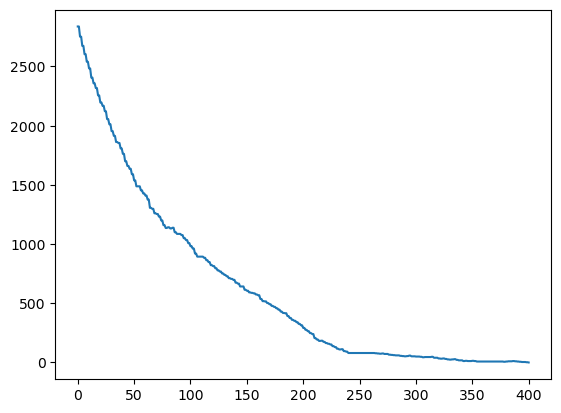

In [215]:
plt.plot(history)

In [183]:
s = random_init(1000, 32)
%time result, history = improve_until_covergence(s, max_iters=1000, verbose=True, return_history=True)

Initial solution has 2940 violations
1) 2940 -> 2866
2) 2866 -> 2768
3) 2768 -> 2734
4) 2734 -> 2652
5) 2652 -> 2556
6) 2556 -> 2492
7) 2492 -> 2460
8) 2460 -> 2378
9) 2378 -> 2338
10) 2338 -> 2280
11) 2280 -> 2252
12) 2252 -> 2188
13) 2188 -> 2100
14) 2100 -> 2038
15) 2038 -> 2018
16) 2018 -> 1974
17) 1974 -> 1918
18) 1918 -> 1876
19) 1876 -> 1830
20) 1830 -> 1792
21) 1792 -> 1766
22) 1766 -> 1742
23) 1742 -> 1722
24) 1722 -> 1704
25) 1704 -> 1644
26) 1644 -> 1632
27) 1632 -> 1602
28) 1602 -> 1568
29) 1568 -> 1540
30) 1540 -> 1526
31) 1526 -> 1474
32) 1474 -> 1444
33) 1444 -> 1410
34) 1410 -> 1390
35) 1390 -> 1382
36) 1382 -> 1398
37) 1398 -> 1374
38) 1374 -> 1354
39) 1354 -> 1330
40) 1330 -> 1306
41) 1306 -> 1298
42) 1298 -> 1266
43) 1266 -> 1270
44) 1270 -> 1236
45) 1236 -> 1228
46) 1228 -> 1200
47) 1200 -> 1180
48) 1180 -> 1178
49) 1178 -> 1146
50) 1146 -> 1128
51) 1128 -> 1118
52) 1118 -> 1102
53) 1102 -> 1110
54) 1110 -> 1108
55) 1108 -> 1074
56) 1074 -> 1064
57) 1064 -> 1044
58)

KeyboardInterrupt: 

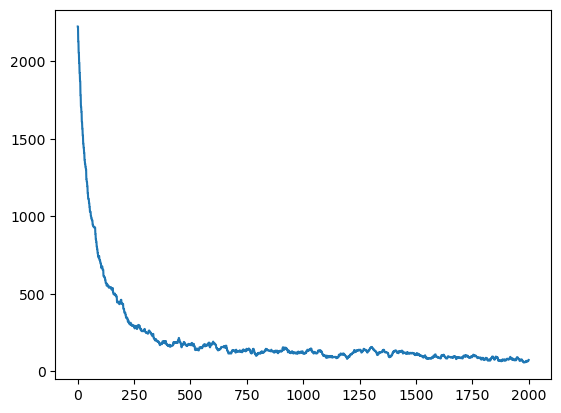

In [112]:
plt.plot(history)

In [114]:
s = random_init(1000, 24)
%time result, history = improve_until_covergence(s, max_iters=1000, verbose=True, return_history=True)

Initial solution has 1476 violations
1) 1476 -> 1424
2) 1424 -> 1362
3) 1362 -> 1302
4) 1302 -> 1228
5) 1228 -> 1168
6) 1168 -> 1116
7) 1116 -> 1046
8) 1046 -> 1004
9) 1004 -> 974
10) 974 -> 966
11) 966 -> 924
12) 924 -> 880
13) 880 -> 844
14) 844 -> 832
15) 832 -> 802
16) 802 -> 752
17) 752 -> 730
18) 730 -> 696
19) 696 -> 688
20) 688 -> 674
21) 674 -> 650
22) 650 -> 646
23) 646 -> 626
24) 626 -> 614
25) 614 -> 594
26) 594 -> 606
27) 606 -> 584
28) 584 -> 558
29) 558 -> 532
30) 532 -> 518
31) 518 -> 492
32) 492 -> 466
33) 466 -> 448
34) 448 -> 440
35) 440 -> 428
36) 428 -> 412
37) 412 -> 410
38) 410 -> 388
39) 388 -> 368
40) 368 -> 336
41) 336 -> 322
42) 322 -> 300
43) 300 -> 304
44) 304 -> 306
45) 306 -> 314
46) 314 -> 284
47) 284 -> 260
48) 260 -> 244
49) 244 -> 244
50) 244 -> 242
51) 242 -> 234
52) 234 -> 222
53) 222 -> 224
54) 224 -> 222
55) 222 -> 210
56) 210 -> 192
57) 192 -> 186
58) 186 -> 182
59) 182 -> 172
60) 172 -> 166
61) 166 -> 154
62) 154 -> 148
63) 148 -> 138
64) 138 ->

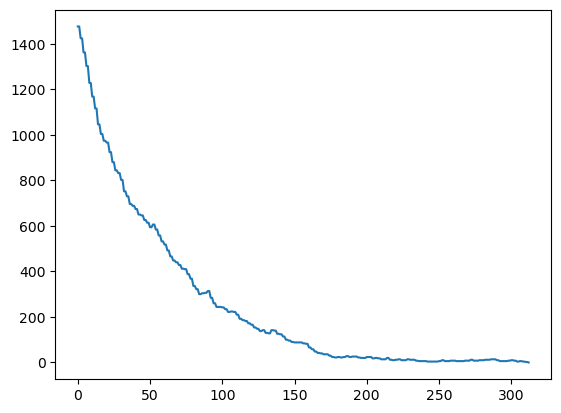

In [115]:
plt.plot(history)

In [116]:
s

{0: {0: array([747, 128, 693, 676, 797, 376, 223, 424,  21, 181, 174, 938, 666,
         177, 205, 451, 257, 885, 475, 767, 936, 409, 875, 598]),
  1: array([932, 874, 979, 562, 307, 970, 333,  19, 301, 436, 106, 335, 102,
         674, 446, 356, 295, 945, 766, 607, 139, 859,  50, 486]),
  2: array([438, 160, 600,  55,   2, 841, 881, 831, 799, 122, 590, 312, 266,
         821, 209, 974, 933, 478, 929, 552, 720, 347, 372, 368]),
  3: array([650, 242, 761, 653,  14, 479, 510, 101, 405, 985, 439, 734, 311,
          79, 951, 865, 796, 245, 893, 587, 645, 567, 563, 805]),
  4: array([890, 887, 686, 732, 329, 564, 741,  18, 456, 199, 735, 217, 958,
         271, 442,  88, 412, 809, 506, 386, 449, 901, 144,  15]),
  5: array([490, 884, 944,  31, 359, 776, 119, 176, 662, 864, 906, 615, 553,
         304, 400, 632, 129, 429, 942, 670, 649,  39, 561,  12]),
  6: array([555, 364,   9,   8, 267, 343, 581,  28, 379, 705, 243, 905, 773,
         852, 774, 448, 820, 458, 533, 955, 415, 560, 822, 403